In [0]:
# dbutils.secrets.list(scope="dbscope")

In [0]:
import json

client_id_secret = dbutils.secrets.get(scope="dbscope", key="clients-id")
client_secret_secret = dbutils.secrets.get(scope="dbscope", key="clients-secret")

configs = {
  "fs.azure.account.auth.type": "OAuth",
  "fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
  "fs.azure.account.oauth2.client.id": client_id_secret,
  "fs.azure.account.oauth2.client.secret": client_secret_secret,
  "fs.azure.account.oauth2.client.endpoint": "https://login.microsoftonline.com/61d9d578-f844-4b35-ba98-e2d55576d814/oauth2/token"
}

dbutils.fs.mount(
source = "abfss://crimescontainer@crimesdata.dfs.core.windows.net",
mount_point = "/mnt/crimes",
extra_configs = configs)

In [0]:
%fs
ls "/mnt/crimes"

path,name,size,modificationTime
dbfs:/mnt/crimes/raw-data/,raw-data/,0,1703048744000
dbfs:/mnt/crimes/transformed-data/,transformed-data/,0,1703048756000


In [0]:
spark

# Load Data

In [0]:
city = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/mnt/crimes/raw-data/city.csv")
complaints = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/mnt/crimes/raw-data/complaints.csv")
states = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/mnt/crimes/raw-data/states.csv")

# Crime Rates Prediction Model

In [0]:
city.show()

+----+----------------+-----+-----+-----+----------+----------------------+-------------------+
|S.No|            City| 2019| 2020| 2021|Population|RateofCognizableCrimes|ChargesSheetingRate|
+----+----------------+-----+-----+-----+----------+----------------------+-------------------+
|   1|            Agra| 6510| 6285| 5665|      17.5|                 324.5|               58.0|
|   2|       Allahabad| 5621| 5455| 4130|      12.2|                 339.4|               68.2|
|   3|        Amritsar| 2589| 3178| 3349|      11.8|                 282.9|               54.8|
|   4|         Asansol| 4244| 4335| 4864|      12.4|                 391.3|               95.8|
|   5|      Aurangabad| 5636| 6248| 7366|      11.9|                 619.5|               82.6|
|   6|          Bhopal|15367|18329|18831|      18.8|                1000.1|               88.3|
|   7| Chandigarh City| 2819| 2583| 2401|      10.3|                 234.0|               67.7|
|   8|         Dhanbad| 2102| 2801| 2508

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
spark = SparkSession.builder.appName("CrimeRatesPrediction").getOrCreate()

In [0]:
feature_columns = ["2019", "2020", "2021", "Population", "ChargesSheetingRate"]
target_column = "RateofCognizableCrimes"

In [0]:
train_data, test_data = crime_data.randomSplit([0.8, 0.2], seed=42)

In [0]:
lr = LinearRegression(featuresCol="features", labelCol=target_column)

In [0]:
pipeline = Pipeline(stages=[lr])

In [0]:
model = pipeline.fit(train_data)

In [0]:
predictions = model.transform(test_data)

In [0]:
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data: {mse}")

Mean Squared Error (MSE) on test data: 6950.631718800905


In [0]:
model.save("crime_rates_prediction_model")

In [0]:
sample_data = crime_data.limit(5)

In [0]:
sample_predictions = model.transform(sample_data)

In [0]:
sample_predictions.select("City", "features", "prediction").show()

+----------+--------------------+------------------+
|      City|            features|        prediction|
+----------+--------------------+------------------+
|      Agra|[6510.0,6285.0,56...| 293.0083022451103|
| Allahabad|[5621.0,5455.0,41...| 363.5281883069188|
|  Amritsar|[2589.0,3178.0,33...| 328.5821759116189|
|   Asansol|[4244.0,4335.0,48...|402.74243357475046|
|Aurangabad|[5636.0,6248.0,73...| 591.2158147725447|
+----------+--------------------+------------------+



In [0]:
import matplotlib.pyplot as plt
import pandas as pd

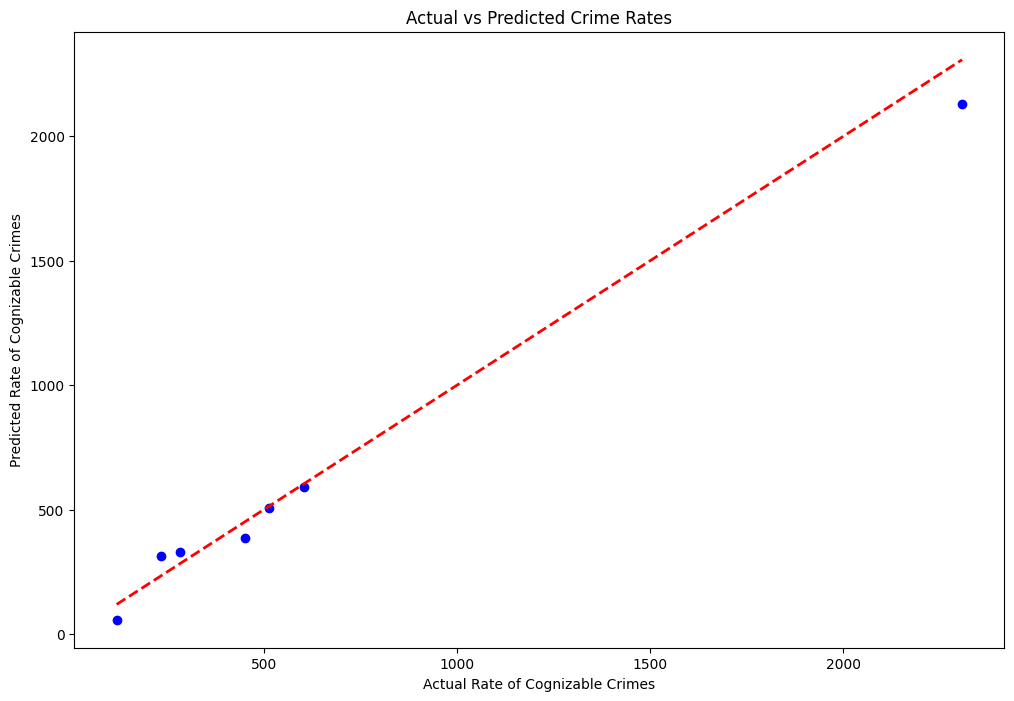

In [0]:
all_predictions = model.transform(test_data)

all_predictions_pd = all_predictions.select("City", "RateofCognizableCrimes", "prediction").toPandas()

plt.figure(figsize=(12, 8))
plt.scatter(all_predictions_pd['RateofCognizableCrimes'], all_predictions_pd['prediction'], color='blue')
plt.plot([min(all_predictions_pd['RateofCognizableCrimes']), max(all_predictions_pd['RateofCognizableCrimes'])],
         [min(all_predictions_pd['RateofCognizableCrimes']), max(all_predictions_pd['RateofCognizableCrimes'])],
         linestyle='--', color='red', linewidth=2)
plt.title('Actual vs Predicted Crime Rates')
plt.xlabel('Actual Rate of Cognizable Crimes')
plt.ylabel('Predicted Rate of Cognizable Crimes')
plt.show()

# EDA on crimes complaint

In [0]:
complaints.show()

+--------------------+-------------+-------+-------------+
|    TypeofComplaints|#ofComplaints|#ofFIRs|#ofOnlineFIRS|
+--------------------+-------------+-------+-------------+
|     Oral Complaints|      8585351| 690094|            0|
|Narrated to O/C /...|       930369| 621456|            0|
|Distress call ove...|      7654982|  68638|            0|
|  Written Complaints|      8894954|5220773|       185443|
|        To O/C / SHO|      4709804|3496161|            0|
|To SP/Senior Offi...|      1275123| 127955|            0|
|     Electronic Form|       681373|  15510|       185443|
|    Court Complaints|       111812| 105939|            0|
|         NHRC & SHRC|        22855|    885|            0|
| Commissions for SCs|         7348|    208|            0|
| Commissions for STs|         2747|     84|            0|
|National/State Co...|        36855|   1237|            0|
|Children Welfare ...|         2332|    333|            0|
|Complaints Initia...|      1497410|1366458|            

In [0]:
complaints.describe().show()

+-------+--------------------+------------------+------------------+------------------+
|summary|    TypeofComplaints|     #ofComplaints|           #ofFIRs|     #ofOnlineFIRS|
+-------+--------------------+------------------+------------------+------------------+
|  count|                  15|                15|                15|                15|
|   mean|                NULL|2330707.3333333335|          788115.6|24725.733333333334|
| stddev|                NULL| 3355576.636240093|1533812.9571439556|  65251.0449642288|
|    min|Any Others Writte...|              2332|                84|                 0|
|    max|  Written Complaints|           8894954|           5220773|            185443|
+-------+--------------------+------------------+------------------+------------------+



In [0]:
import seaborn as sns

In [0]:
numeric_columns = ["#ofComplaints", "#ofFIRs", "#ofOnlineFIRS"]

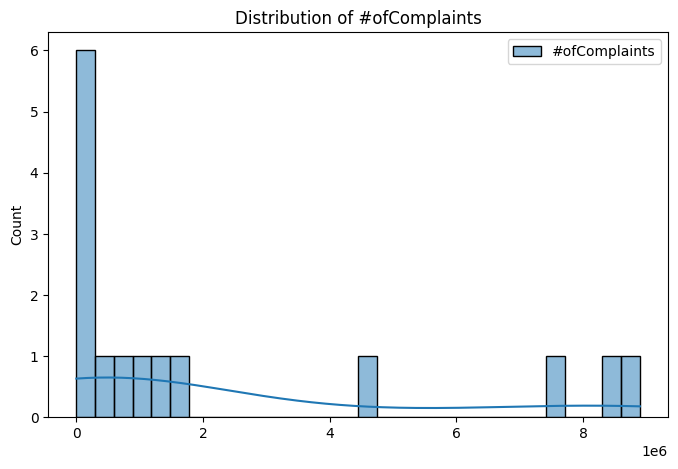

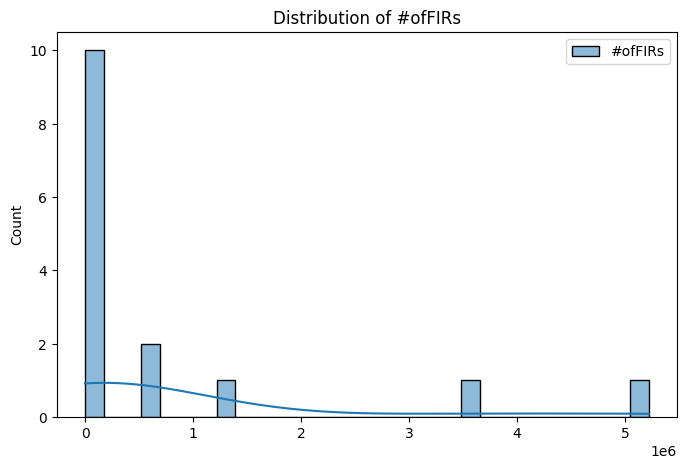

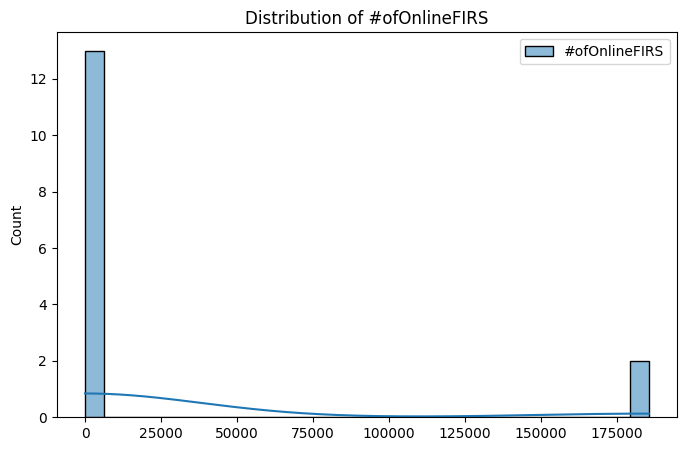

In [0]:
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(complaints.select(column).toPandas(), bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

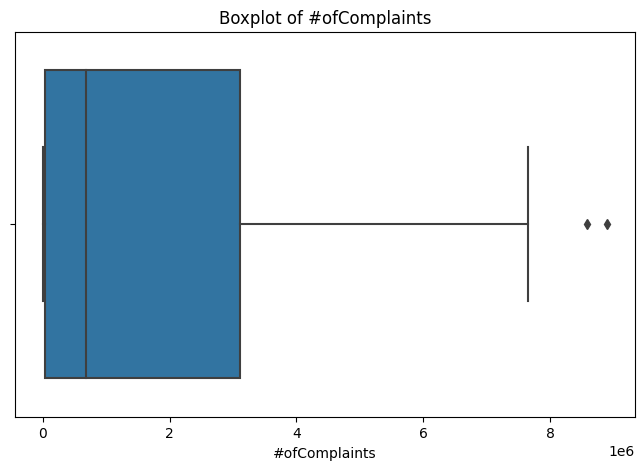

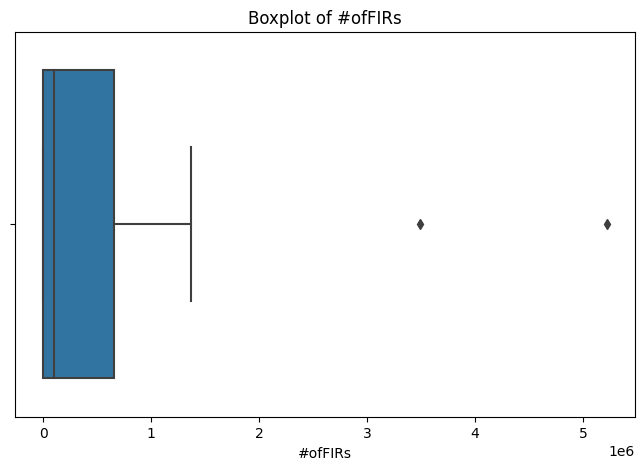

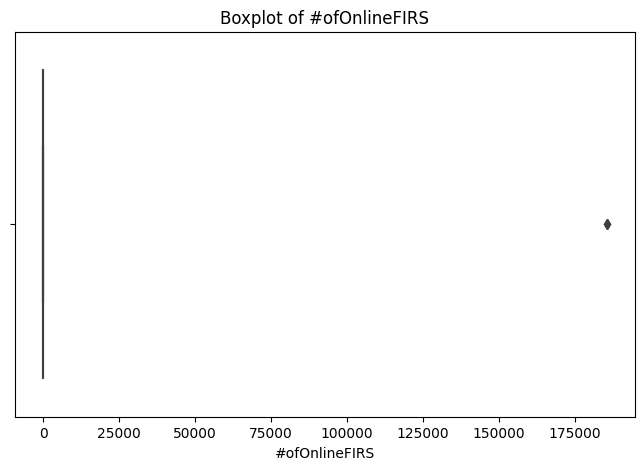

In [0]:
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=complaints.select(column).toPandas()[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

# EDA on states

In [0]:
states.show()

+----+--------+-----------------+------+------+------+-------------+----------------------+-------------------+
|S.No|State/UT|             Name|  2019|  2020|  2021|midPopulation|RateofCognizableCrimes|ChargesSheetingRate|
+----+--------+-----------------+------+------+------+-------------+----------------------+-------------------+
|   1|   State|   Andhra Pradesh|119229|188997|179611|        528.5|                 339.9|               92.9|
|   2|   State|Arunachal Pradesh|  2590|  2244|  2626|         15.4|                 170.9|               51.7|
|   3|   State|            Assam|123512|111558|119883|        351.6|                 341.0|               38.2|
|   4|   State|            Bihar|197935|194698|186006|       1237.0|                 150.4|               70.5|
|   5|   State|     Chhattisgarh| 61256| 65216| 70519|        296.1|                 238.2|               80.2|
|   6|   State|              Goa|  2465|  3393|  2099|         15.6|                 134.5|             

### Total crimes

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

In [0]:
spark = SparkSession.builder.appName("CrimesSum").getOrCreate()

In [0]:
crimes_2019 = states.agg(sum("2019")).collect()[0][0]
crimes_2020 = states.agg(sum("2020")).collect()[0][0]
crimes_2021 = states.agg(sum("2021")).collect()[0][0]

In [0]:
total_crimes = crimes_2019+crimes_2020+crimes_2021
print("Total crimes in India: ", total_crimes)

Total crimes in India:  11143313.0


### Total crime on basis of year

In [0]:
spark = SparkSession.builder.appName("CrimesPlot").getOrCreate()

In [0]:
crimes_totals = states.groupBy().agg(sum("2019").alias("2019"), sum("2020").alias("2020"), sum("2021").alias("2021")).collect()[0]

In [0]:
crimes_df = pd.Series([crimes_totals['2019'], crimes_totals['2020'], crimes_totals['2021']], index=['2019', '2020', '2021'])

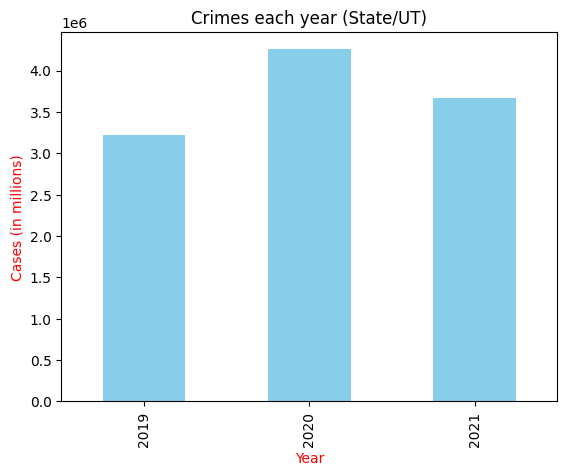

In [0]:
crimes_df.plot(kind='bar', color='skyblue')

plt.xlabel("Year", color="red")
plt.ylabel("Cases (in millions)", color="red")
plt.title("Crimes each year (State/UT)")

plt.show()